# Tarea Obligatoria
Utilizar una librería para calcular las componentes principales e interpretar la PC1 (gráfica y teóricamente).

*Usar el dataset de paises de Europa.*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
df = pd.read_csv("../data/europe.csv")
df = df.set_index("Country")
df.head()

,Area,GDP,Inflation,Life.expect,Military,Pop.growth,Unemployment
Country,,,,,,,
Austria,83871,41600,3.5,79.91,0.80,0.03,4.2
Belgium,30528,37800,3.5,79.65,1.30,0.06,7.2
Bulgaria,110879,13800,4.2,73.84,2.60,-0.80,9.6
Croatia,56594,18000,2.3,75.99,2.39,-0.09,17.7
Czech Republic,78867,27100,1.9,77.38,1.15,-0.13,8.5


## Exploración de los datos

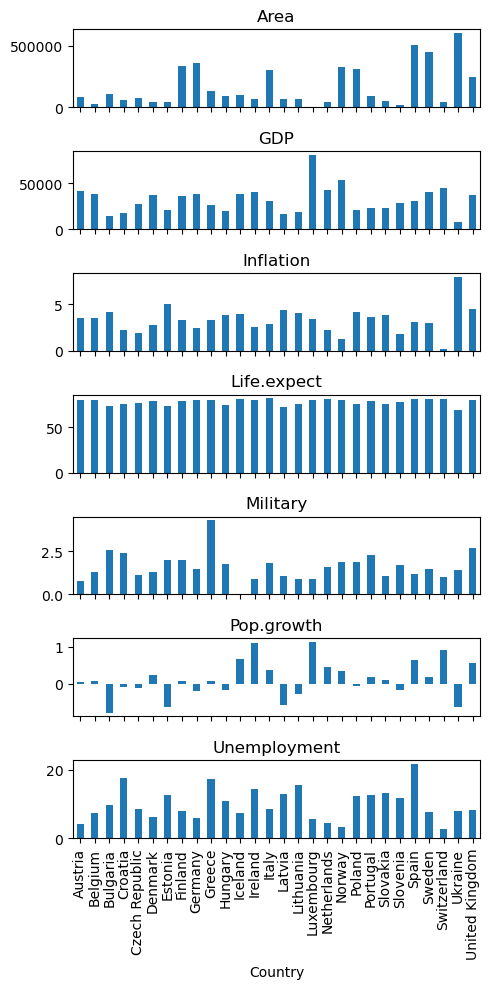

In [3]:
fig, ax = plt.subplots(len(df.columns), 1, sharex=True, figsize=(5,10))

for i, c in enumerate(df.columns):
    df[c].plot(kind="bar", ax=ax[i], title=c)

plt.tight_layout()
plt.show()

## Escalado del conjunto de datos

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(df)

## PCA

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=len(df.columns))
pca.fit(x_scaled)

PCA(n_components=7)

Observamos que graficando los dos primeros componentes principales, podemos explicar más del 60 % de la variabilidad del conjunto de datos.

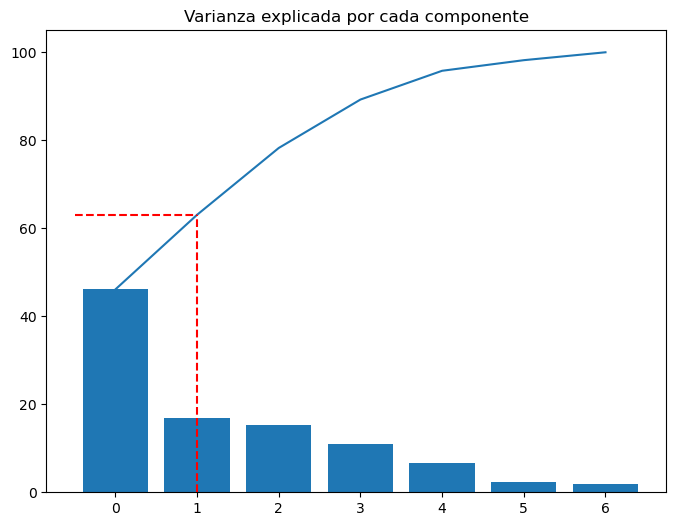

In [6]:
fig, ax = plt.subplots(1, figsize=(8, 6))

componentes = np.arange(len(df.columns))
plt.plot(componentes, pca.explained_variance_ratio_.cumsum() * 100)
plt.bar(componentes, pca.explained_variance_ratio_ * 100)

comp_dos = pca.explained_variance_ratio_.cumsum()[1] * 100
plt.hlines(comp_dos, -0.5, 1, linestyles="dashed", color="red")
plt.vlines(1, 0 , comp_dos, linestyles="dashed", color="red")

plt.title("Varianza explicada por cada componente")
plt.show()


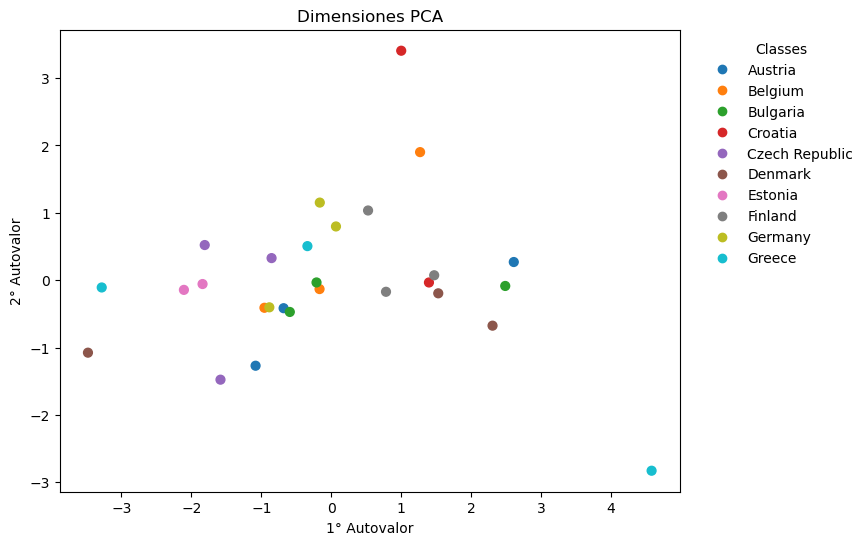

In [7]:
fig, ax = plt.subplots(1, figsize=(8, 6))

country_to_id = {country: i for i, country in enumerate(df.index)}
country_ids = [country_to_id[country] for country in df.index]

X_reduced = pca.fit_transform(x_scaled)
scatter = ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=country_ids,
    s=40,
    cmap="tab10",
)

ax.set(
    title="Dimensiones PCA",
    xlabel="1° Autovalor",
    ylabel="2° Autovalor",
)

# Add a legend
legend1 = ax.legend(
    scatter.legend_elements()[0],
    df.index.tolist(),
    loc="upper right",
    title="Classes",
    bbox_to_anchor=(1.3, 1),
    frameon=False
)

plt.show()

In [8]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=df.columns,
    columns=["PC{}".format(i+1) for i, _ in enumerate(pca.components_)]
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Area,0.124874,-0.172872,0.898297,0.044850,-0.324017,0.190118,0.066643
GDP,-0.500506,-0.130140,0.083956,-0.084255,0.390632,0.638657,-0.397408
Inflation,0.406518,-0.369657,0.198195,0.164686,0.689501,-0.323867,-0.226700
Life.expect,-0.482873,0.265248,0.246082,0.026771,-0.101787,-0.606434,-0.507031
Military,0.188112,0.658267,0.243679,-0.562375,0.368148,0.035596,0.137310
Pop.growth,-0.475704,0.082622,0.163697,0.392463,0.347868,-0.120856,0.671147
Unemployment,0.271656,0.553204,0.000500,0.701968,0.010159,0.259705,-0.244662


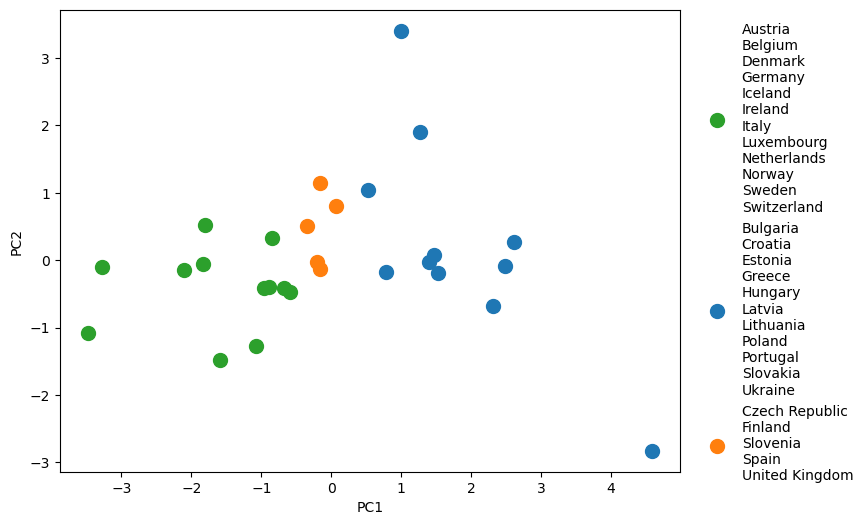

In [9]:
import sys; sys.path.append("..")
from src.kohonen import Kohonen
#from sklearn_som.som import SOM

def kohonen(x):
    #som = SOM(m=2, n=2, dim=7)
    #som.fit(x, epochs=100)
    #return som.predict(x)

    dims_out = (3, 1)
    som = Kohonen(7, dims_out)
    som.train(x, epochs=100, decay=True, shuffle=False)
    pred = som.predict(x)
    pred = [np.ravel_multi_index(p, dims_out) for p in pred]
    return pred
    
X_reduced = pca.fit_transform(x_scaled)

df["PC1"] = X_reduced[:, 0]
df["PC2"] = X_reduced[:, 1]

predictions = kohonen(X_reduced)
df["predictions"] = predictions


fig, ax = plt.subplots(1, figsize=(8, 6))
for i, pred in enumerate(df.predictions.unique()):
    tmp = df[df.predictions == pred]
    tmp.plot.scatter("PC1", "PC2", color=plt.cm.tab10(pred), colorbar=False, ax=ax, s=100, label="\n".join(tmp.index))

plt.legend(bbox_to_anchor=(1.3, 1), frameon=False)
plt.show()

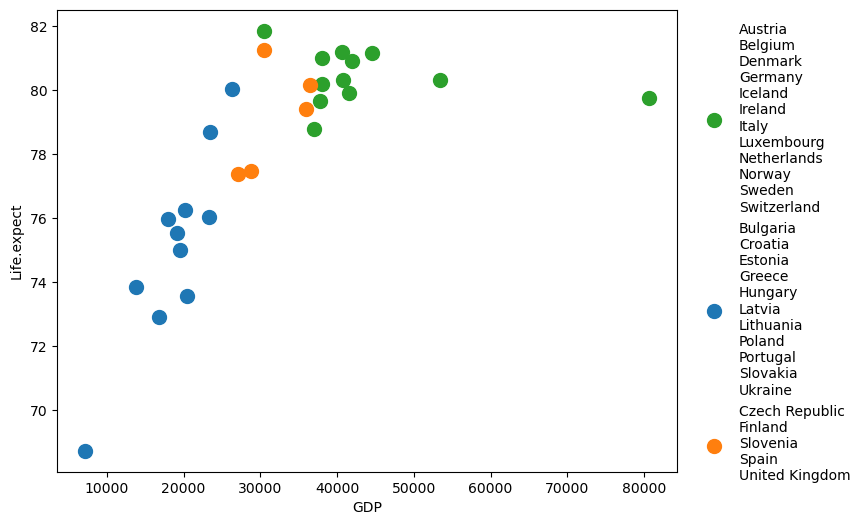

In [10]:
fig, ax = plt.subplots(1, figsize=(8, 6))
for i, pred in enumerate(df.predictions.unique()):
    tmp = df[df.predictions == pred]
    tmp.plot.scatter("GDP", "Life.expect", color=plt.cm.tab10(pred), colorbar=False, ax=ax, s=100, label="\n".join(tmp.index))
plt.legend(bbox_to_anchor=(1.3, 1), frameon=False)
plt.show()

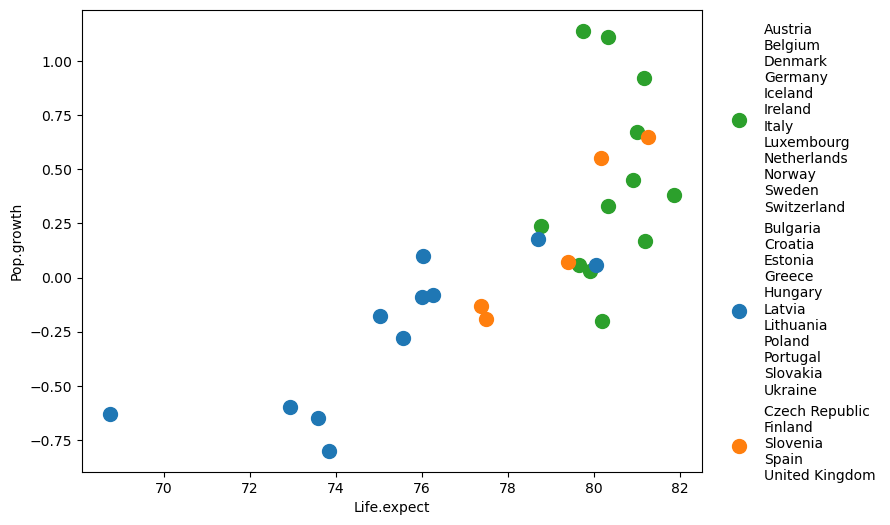

In [11]:
fig, ax = plt.subplots(1, figsize=(8, 6))
for i, pred in enumerate(df.predictions.unique()):
    tmp = df[df.predictions == pred]
    tmp.plot.scatter("Life.expect", "Pop.growth", color=plt.cm.tab10(pred), colorbar=False, ax=ax, s=100, label="\n".join(tmp.index))
plt.legend(bbox_to_anchor=(1.3, 1), frameon=False)
plt.show()